In [50]:
# Connect to MariaDB Platform
# Module Imports
import mariadb
import sys
import configparser
config  = configparser.ConfigParser()
config.read('config.ini')

try:
    conn = mariadb.connect(
        user=config["setting"]["user"],
        password=config["setting"]["password"],
        host=config["setting"]["host"],
        port=int(config["setting"]["port"]),
        database=config["setting"]["database"]

    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

# Get Cursor
cur = conn.cursor()

## Prepare SQL query cmd

In [51]:
import datetime
sensor_code = "6f01be05" # main_farm: 6f01be05  # CO2 exp: a1578703
features = ["entity_id", "state", "last_updated"]
base_cmd = f'select {", ".join(features)} from states where'
data_types = ["carbon_dioxide_concentration", "humidity", "temperature"]

t_begin_unix = 1649674801
t_end_unix =   1650279601

t_begin = str(datetime.datetime.fromtimestamp(t_begin_unix).strftime('%Y-%m-%d %H:%M:%S'))
t_end = str(datetime.datetime.fromtimestamp(t_end_unix).strftime('%Y-%m-%d %H:%M:%S'))
print("Begin: ",t_begin)
print("End: ",t_end)

Begin:  2022-04-11 13:00:01
End:  2022-04-18 13:00:01


Combine the proper SQL query

In [52]:
entity_cmd_list = []
for data_type in data_types:
    entity_cmd_list.append(f'entity_id like "%{sensor_code}_{data_type}%"')
entity_cmd = "(" +  ' or '.join(entity_cmd_list) + ")"
full_cmd = f"{base_cmd} {entity_cmd} and last_updated <='{t_end}' and last_updated >='{t_begin}'" 
print(full_cmd)

select entity_id, state, last_updated from states where (entity_id like "%6f01be05_carbon_dioxide_concentration%" or entity_id like "%6f01be05_humidity%" or entity_id like "%6f01be05_temperature%") and last_updated <='2022-04-18 13:00:01' and last_updated >='2022-04-11 13:00:01'


In [53]:
cur.execute(full_cmd)
vals = [_ for _ in cur]

In [242]:
import pandas as pd
import numpy as np
from typing import List
from scipy.stats import zscore

df_home = pd.DataFrame.from_records(vals, columns=features)
df_home["time_s"] = df_home["last_updated"].apply(lambda x: np.int64(pd.to_datetime(x).timestamp())) 

## Load atlatics data

In [55]:
df_at = pd.read_csv("feeds-main-farm.csv", names=["time", "id", "ph", "EC", "water_T", "lat", "longi", "elevation", "status"])
df_at = df_at.drop(["id","lat","longi","elevation","status"], axis=1) # delete redundant columns
df_at = df_at.drop([0], axis=0) # delete the name filed
df_at["time_s"] = df_at.time.apply(lambda x: np.int64(pd.to_datetime(x).timestamp())) # convert to unix time step
df_at[["ph", "EC", "water_T"]] = df_at[["ph", "EC", "water_T"]].apply(pd.to_numeric) # conver to numeric value

/home/hexaburbach/anaconda3/envs/analysis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [243]:
df_home[df_home.state=="unavailable"] # should deal with unavailable data type.

,entity_id,state,last_updated,time_s
3416,sensor.titan_products_ltd_tpzrco2ht_z3_6f01be0...,unavailable,2022-04-18 10:36:19.078752,1650278179
3417,sensor.titan_products_ltd_tpzrco2ht_z3_6f01be0...,unavailable,2022-04-18 10:36:19.078770,1650278179
3418,sensor.titan_products_ltd_tpzrco2ht_z3_6f01be0...,unavailable,2022-04-18 10:36:19.078807,1650278179


In [244]:
df_home["sensor"] = df_home.entity_id.str.split('_').str[-1]
df_home["state"] = df_home["state"].replace({'unavailable':np.nan})
df_home.state = df_home.state.astype(np.float16)

## Create columns for features

In [245]:
df_home = pd.get_dummies(df_home, columns=['sensor'])
df_home = df_home.rename(columns={'sensor_concentration':'CO2', 'sensor_humidity':'humidity','sensor_temperature':'air_T'})
df_home.CO2 = df_home.CO2 * df_home.state
df_home.humidity = df_home.humidity * df_home.state
df_home.air_T = df_home.air_T * df_home.state

## Filter data frames

In [246]:
df_home[["CO2", "humidity", "air_T"]] = df_home[["CO2", "humidity", "air_T"]].replace({'0':np.nan, 0:np.nan})
df_at_fit = df_at[(df_at.time_s>t_begin_unix)  & (df_at.time_s<t_end_unix)]

## Load area files

In [247]:
GROW_FILE = 'hexa_volume6.csv'
df_grow = pd.read_csv(GROW_FILE)
df_grow['time_s'] = df_grow['file_name'].apply(lambda x: x.split('-')[-1].split('.')[0]).astype(np.int64)
df_grow = df_grow.drop("file_name", axis=1)

## Merge different data frames

In [275]:
from functools import reduce
df_merge = reduce(lambda left, right: pd.merge(left, right, how="outer", on="time_s"), [df_home, df_at_fit, df_grow])
df_merge = df_merge.drop(["entity_id", "state", "last_updated", "time"], axis=1)
df_merge.head(10)

,time_s,CO2,humidity,air_T,ph,EC,water_T,area_cm2,volume_cm3
0,1649682040,NaN,33.593750,NaN,NaN,NaN,NaN,NaN,NaN
1,1649682101,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN
2,1649682222,NaN,34.812500,NaN,NaN,NaN,NaN,NaN,NaN
3,1649682312,NaN,35.812500,NaN,10.21,1426.0,18.53,NaN,NaN
4,1649682343,NaN,34.406250,NaN,NaN,NaN,NaN,NaN,NaN
5,1649682373,NaN,33.312500,NaN,NaN,NaN,NaN,NaN,NaN
6,1649682373,398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1649682433,NaN,34.906250,NaN,NaN,NaN,NaN,NaN,NaN
8,1649682494,NaN,33.093750,NaN,NaN,NaN,NaN,NaN,NaN
9,1649682524,NaN,31.703125,NaN,NaN,NaN,NaN,NaN,NaN


## Create relative time
This is time starting from the beginning of the batch

In [276]:
df_merge["time_rel"] = df_merge.time_s - df_merge.time_s.min()
df_merge = df_merge.sort_values(by="time_rel")
df_merge = df_merge.drop("time_s", axis=1).set_index("time_rel")
df_merge = df_merge.interpolate('index',  limit_direction='both')
df_merge.head(10)

,CO2,humidity,air_T,ph,EC,water_T,area_cm2,volume_cm3
time_rel,,,,,,,,
0,398.0,33.59375,19.0,9.76,1418.0,18.05,110.000000,125.000000
16,398.0,33.59375,19.0,9.76,1418.0,18.05,109.945556,124.918889
48,398.0,33.59375,19.0,9.76,1418.0,18.05,109.836667,124.756667
79,398.0,33.59375,19.0,9.76,1418.0,18.05,109.731181,124.599514
112,398.0,33.59375,19.0,9.76,1420.0,18.05,109.618889,124.432222
146,398.0,33.59375,19.0,9.76,1419.0,18.06,109.503194,124.259861
178,398.0,33.59375,19.0,9.75,1419.0,18.06,109.394306,124.097639
214,398.0,33.59375,19.0,9.75,1421.0,18.05,109.271806,123.915139
247,398.0,33.59375,19.0,9.76,1419.0,18.07,109.159514,123.747847


<AxesSubplot:xlabel='time_rel'>

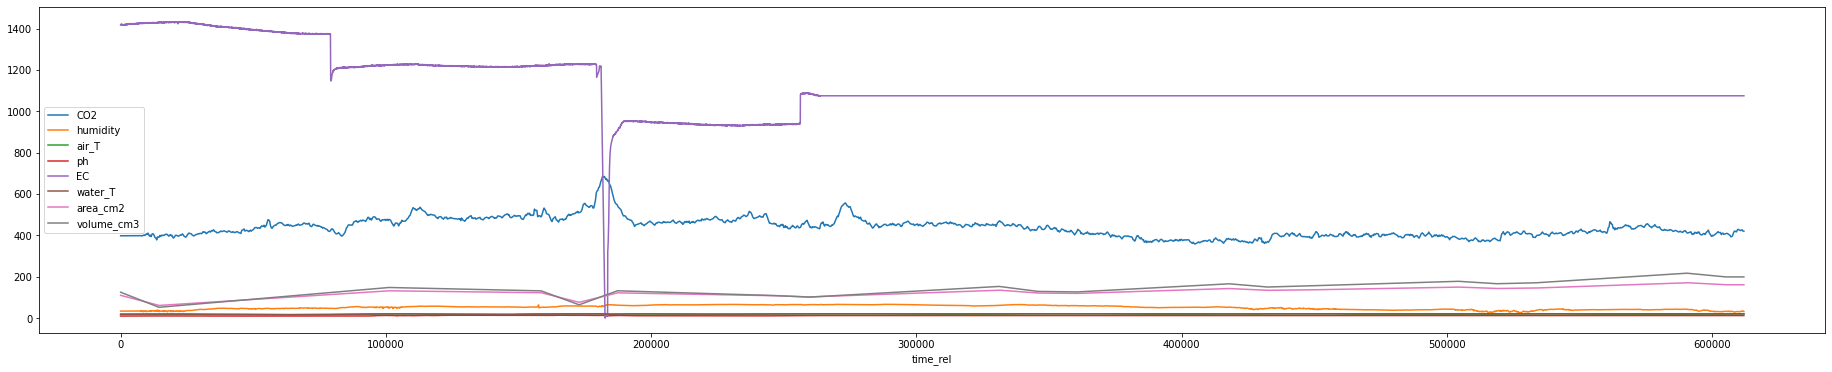

In [277]:
df_merge.plot(figsize=(32, 6))

## Eleminate sensor error (Dealing with outliers)

Outliers are detected in EC: 


time_rel
0         1418.0
16        1418.0
48        1418.0
79        1418.0
112       1420.0
           ...  
256058     939.0
256091     939.0
256122     939.0
256153     939.0
256184     939.0
Name: EC, Length: 5766, dtype: float64

After treating outliers in EC: 


time_rel
0                 NaN
16                NaN
48                NaN
79                NaN
112               NaN
             ...     
256058    1077.851209
256091    1077.882684
256122    1077.912252
256153    1077.941819
256184    1077.971386
Name: EC, Length: 5766, dtype: float64

Outliers are detected in ph: 


time_rel
0          9.760000
16         9.760000
48         9.760000
79         9.760000
112        9.760000
            ...    
181509    13.030353
181690    12.959180
181751    12.935193
181902    12.875817
181932    12.864020
Name: ph, Length: 4626, dtype: float64

After treating outliers in ph: 


time_rel
0               NaN
16              NaN
48              NaN
79              NaN
112             NaN
            ...    
181509    12.837722
181690    12.843516
181751    12.845469
181902    12.850303
181932    12.851263
Name: ph, Length: 4626, dtype: float64

<AxesSubplot:xlabel='time_rel'>

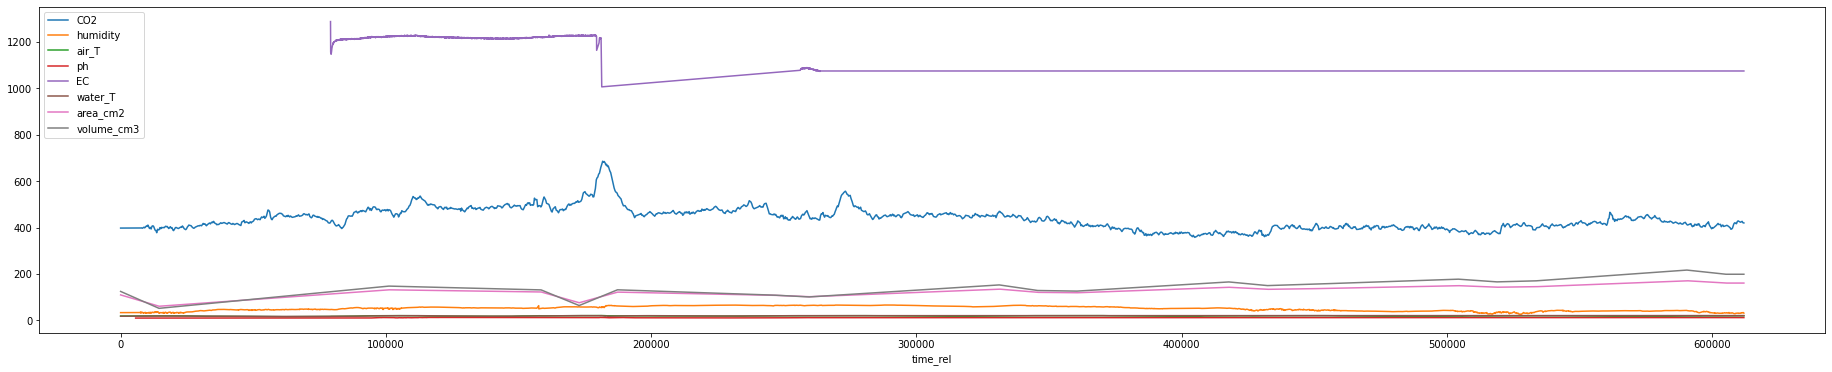

In [285]:
def detect_outlier(df: pd.DataFrame, df_z_score: pd.DataFrame, features: List, thres: int = 5):
    """ Detect outliers using z-score """
    from IPython.display import display
    for feature in features:

        if (abs(df_z_score[feature])>thres).sum():
            print(f"Outliers are detected in {feature}: ")
            display(df[feature][abs(df_z_score[feature])>thres])
            df[feature][abs(df_z_score[feature])>thres] = np.nan
            
            df[feature] = df[feature].interpolate('slinear',  limit_direction='both')
            print(f"After treating outliers in {feature}: ")
            display(df[feature][abs(df_z_score[feature])>thres])
    return df

df_merge_z_score = df_merge.apply(zscore) 
df_merge = detect_outlier(df_merge, df_merge_z_score, ["EC", "ph"], thres=3)
df_merge.plot(figsize=(32, 6))

## Normalize values

<AxesSubplot:xlabel='time_rel'>

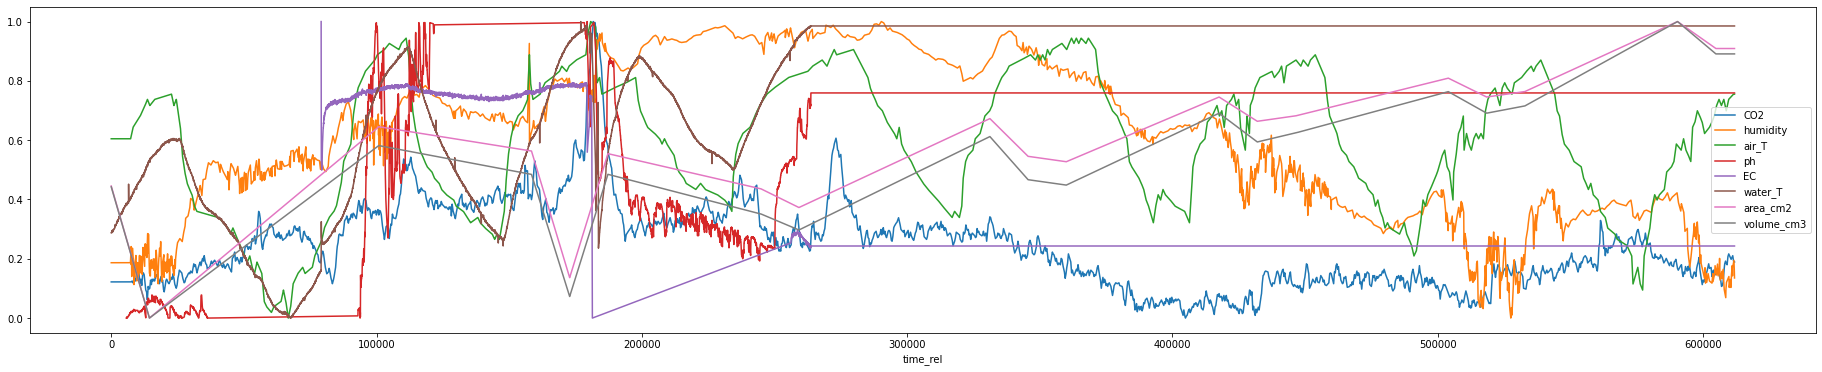

In [286]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
df_merge_scale = pd.DataFrame(scaler.fit_transform(df_merge), columns=df_merge.columns, index=df_merge.index)
df_merge_scale.plot(figsize=(32, 6))

## Correlation map

In [287]:
corr = df_merge_scale.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr.style.background_gradient(cmap='coolwarm').highlight_null(null_color='#f1f1f1').set_precision(2)

/tmp/ipykernel_1183860/1175440308.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').highlight_null(null_color='#f1f1f1').set_precision(2)
/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,CO2,humidity,air_T,ph,EC,water_T,area_cm2,volume_cm3
CO2,nan,nan,nan,nan,nan,nan,nan,nan
humidity,0.60,nan,nan,nan,nan,nan,nan,nan
air_T,0.19,0.20,nan,nan,nan,nan,nan,nan
ph,0.37,0.26,0.39,nan,nan,nan,nan,nan
EC,0.26,-0.24,-0.00,0.40,nan,nan,nan,nan
water_T,-0.04,0.22,0.72,0.55,-0.35,nan,nan,nan
area_cm2,0.09,0.17,0.07,0.56,-0.07,0.41,nan,nan
volume_cm3,0.02,0.07,0.04,0.51,-0.07,0.38,0.99,nan


## Smooth data
It may reduce the performance because it decreases the reality.
But, let's try!

<AxesSubplot:xlabel='time_rel'>

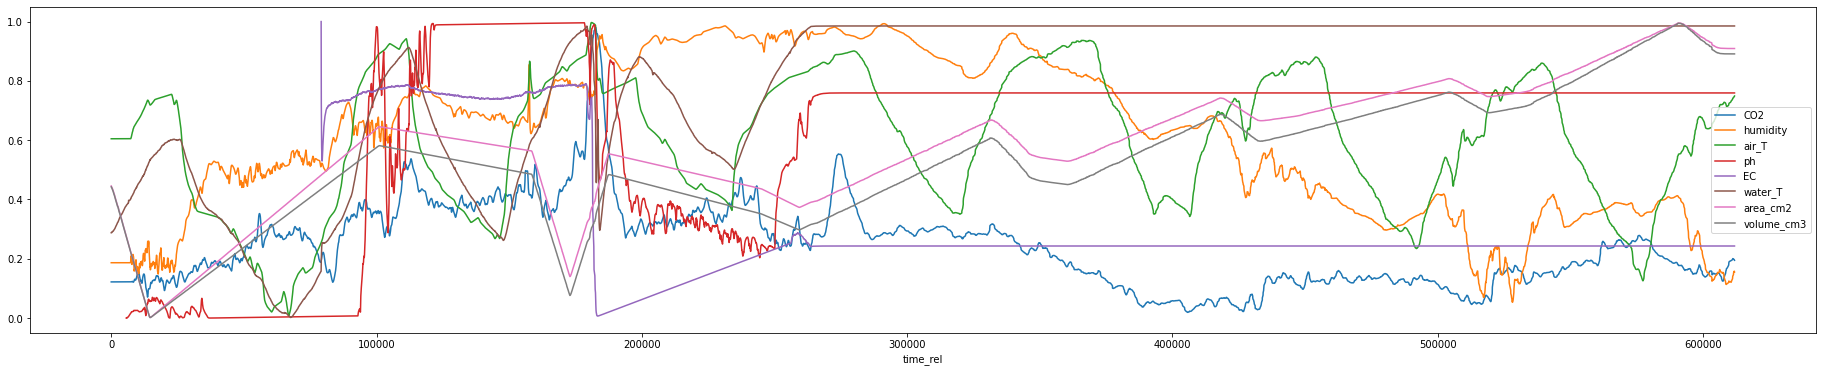

In [288]:
K = 15 # factor 
df_merge_scale_smooth = df_merge_scale.ewm(span = K).mean()
# df_merge_scale_smooth = df_merge_scale.rolling(K).median()
df_merge_scale_smooth.plot(figsize=(32, 6))

In [289]:
corr = df_merge_scale_smooth.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr.style.background_gradient(cmap='coolwarm').highlight_null(null_color='#f1f1f1').set_precision(2)

/tmp/ipykernel_1183860/124462426.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').highlight_null(null_color='#f1f1f1').set_precision(2)
/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,CO2,humidity,air_T,ph,EC,water_T,area_cm2,volume_cm3
CO2,nan,nan,nan,nan,nan,nan,nan,nan
humidity,0.61,nan,nan,nan,nan,nan,nan,nan
air_T,0.19,0.20,nan,nan,nan,nan,nan,nan
ph,0.38,0.26,0.39,nan,nan,nan,nan,nan
EC,0.26,-0.25,-0.00,0.40,nan,nan,nan,nan
water_T,-0.03,0.22,0.72,0.55,-0.35,nan,nan,nan
area_cm2,0.09,0.17,0.07,0.56,-0.07,0.41,nan,nan
volume_cm3,0.02,0.07,0.03,0.51,-0.06,0.38,0.99,nan
